Anomaly Detection for AML Compliance
This notebook compares different anomaly detection algorithms for identifying suspicious behavior in cryptocurrency transactions. We'll evaluate and compare:

Isolation Forest
Local Outlier Factor (LOF)
One-Class SVM
Ensemble approach (majority voting)

Import libraries


In [3]:
#Import libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
#Import custom modules
sys.path.append('..')
from src.models.evaluate import load_data, prepare_features, compare_models, create_comparison_visualizations
#Configure plotting
%matplotlib inline
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

1. Load Processed Data

In [4]:
#Define paths
input_path = '../data/processed/user_metrics.csv'
output_dir = '../data/processed/anomaly_detection'
#Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
#Load data
user_metrics = load_data(input_path)
#Display basic information
print(f"Loaded user metrics data with shape: {user_metrics.shape}")
print(f"Columns: {user_metrics.columns.tolist()}")

2025-03-31 01:50:34,432 - src.models.evaluate - INFO - Loading data from ../data/processed/user_metrics.csv
2025-03-31 01:50:34,437 - src.models.evaluate - INFO - Loaded data with shape (1000, 8)


Loaded user metrics data with shape: (1000, 8)
Columns: ['user_id', 'transaction_count', 'first_transaction', 'last_transaction', 'label_<lambda>', 'kyc_level_first', 'activity_timespan_days', 'tx_per_day']


2. Feature Selection and Preparation
Let's select and prepare the features for anomaly detection.

In [5]:
#Define features to use
feature_columns = [
'transaction_count',
'total_amount',
'avg_amount',
'tx_per_day'
]
#Check if features are present in the dataset
available_features = [col for col in feature_columns if col in user_metrics.columns]
print(f"Available features: {available_features}")
#Prepare features
X, features_used = prepare_features(user_metrics, available_features)
print(f"Prepared feature matrix with shape: {X.shape}")
print(f"Features used: {features_used}")

2025-03-31 01:50:34,448 - src.models.evaluate - INFO - Preparing features for anomaly detection
2025-03-31 01:50:34,449 - src.models.evaluate - INFO - Using features: ['transaction_count', 'tx_per_day']
2025-03-31 01:50:34,451 - src.models.evaluate - INFO - Prepared feature matrix with shape (1000, 2)


Available features: ['transaction_count', 'tx_per_day']
Prepared feature matrix with shape: (1000, 2)
Features used: ['transaction_count', 'tx_per_day']


3. Baseline Model: Isolation Forest
Let's first run the Isolation Forest algorithm as our baseline.

In [6]:
#Set random seed for reproducibility
np.random.seed(42)
#Apply Isolation Forest
contamination = 0.05  # Expect 5% of transactions to be anomalous
model = IsolationForest(contamination=contamination, random_state=42, n_jobs=-1)
model.fit(X)
#Predict anomalies
predictions = model.predict(X)
is_anomaly = (predictions == -1).astype(int)
#Add predictions to the dataframe
user_metrics['is_anomaly_isolation_forest'] = is_anomaly
#Print summary
anomaly_count = is_anomaly.sum()
anomaly_percent = anomaly_count / len(is_anomaly) * 100
print(f"Isolation Forest detected {anomaly_count} anomalies ({anomaly_percent:.2f}% of the data)")

Isolation Forest detected 14 anomalies (1.40% of the data)


4. Visualize Anomalies from Isolation Forest

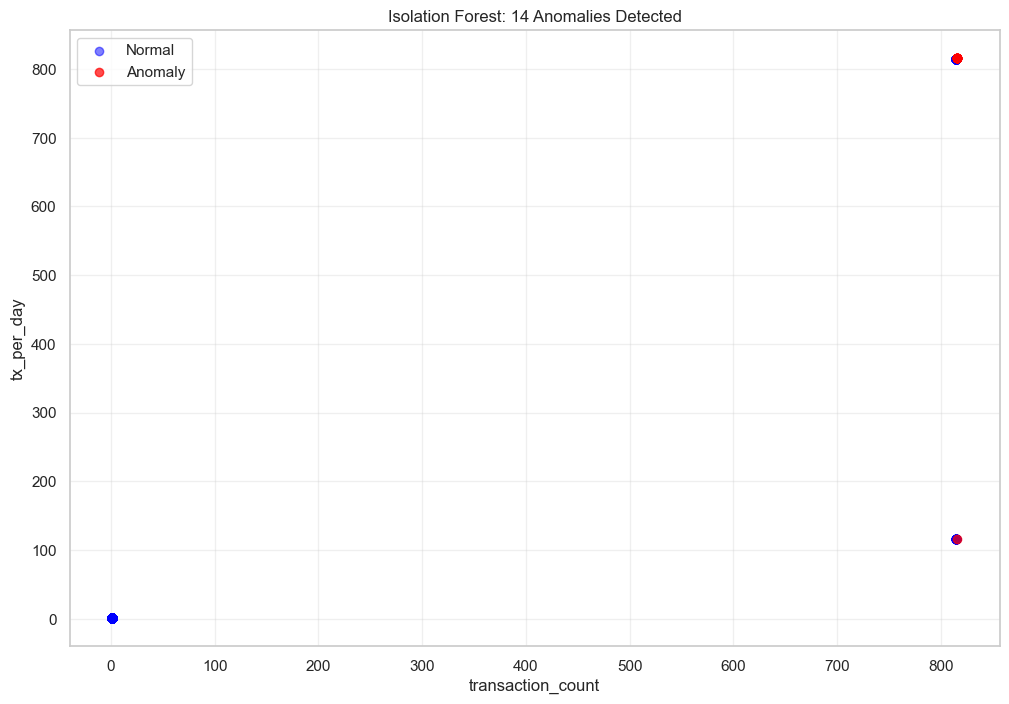

In [7]:
#Choose two features for visualization
feature_x = features_used[0]  # e.g., transaction_count
feature_y = features_used[1]  # e.g., total_amount
#Create scatter plot
plt.figure(figsize=(12, 8))
#Plot normal points
plt.scatter(user_metrics.loc[user_metrics['is_anomaly_isolation_forest'] == 0, feature_x],
user_metrics.loc[user_metrics['is_anomaly_isolation_forest'] == 0, feature_y],
c='blue', label='Normal', alpha=0.5)
#Plot anomalous points
plt.scatter(user_metrics.loc[user_metrics['is_anomaly_isolation_forest'] == 1, feature_x],
user_metrics.loc[user_metrics['is_anomaly_isolation_forest'] == 1, feature_y],
c='red', label='Anomaly', alpha=0.7)
plt.title(f'Isolation Forest: {anomaly_count} Anomalies Detected')
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

5. Compare Multiple Anomaly Detection Algorithms
Let's evaluate and compare multiple anomaly detection algorithms.

In [8]:
#Compare models
results_df, predictions = compare_models(
user_metrics,
feature_names=available_features,
contamination=0.05,
output_dir=output_dir
)
#Display results
print("Model comparison results:")
display(results_df)

2025-03-31 01:50:34,814 - src.models.evaluate - INFO - Comparing anomaly detection models
2025-03-31 01:50:34,814 - src.models.evaluate - INFO - Preparing features for anomaly detection
2025-03-31 01:50:34,815 - src.models.evaluate - INFO - Using features: ['transaction_count', 'tx_per_day']
2025-03-31 01:50:34,817 - src.models.evaluate - INFO - Prepared feature matrix with shape (1000, 2)
2025-03-31 01:50:34,818 - src.models.evaluate - INFO - Evaluating Isolation Forest with contamination=0.05
2025-03-31 01:50:34,963 - src.models.evaluate - INFO - Isolation Forest found 14 anomalies in 0.14 seconds
2025-03-31 01:50:34,964 - src.models.evaluate - INFO - Evaluating Local Outlier Factor with contamination=0.05
c:\Users\HP\OneDrive\Dokumen\Program\data-analys\crypto_aml_analysis\venv\lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
2025-03-31 01:50:3

Model comparison results:


,anomalies_count,anomalies_percent,training_time
Isolation Forest,14.0,1.4,0.144000
Local Outlier Factor,14.0,1.4,0.030002
One-Class SVM,200.0,20.0,0.006000


6. Analyze Anomalies Across Models
Let's examine the characteristics of the anomalies detected by different models.

In [9]:
# Add all model predictions to the dataframe
for model_name, preds in predictions.items(): 
    col_name = f'is_anomaly_{model_name.replace(" ", "_")}' 
    user_metrics[col_name] = preds

# Compare characteristics of anomalies detected by different models
features_to_compare = [ 
    'transaction_count', 
    'total_amount', 
    'avg_amount', 
    'tx_per_day' 
]

# Include only features that exist in the dataframe
features_to_compare = [col for col in features_to_compare if col in user_metrics.columns]

# Create summary statistics for each model
model_columns = [col for col in user_metrics.columns if col.startswith('is_anomaly_')]

for model_col in model_columns: 
    model_name = model_col.replace('is_anomaly_', '').replace('_', ' ') 
    print(f"\n{model_name} Anomaly Characteristics:")
    
    # Calculate statistics for normal vs. anomalous points 
    normal = user_metrics[user_metrics[model_col] == 0][features_to_compare].describe() 
    anomaly = user_metrics[user_metrics[model_col] == 1][features_to_compare].describe() 
    
    # Display statistics side by side 
    comparison = pd.concat([normal.loc[['mean', '50%', 'max']], anomaly.loc[['mean', '50%', 'max']]], 
                           keys=['Normal', 'Anomaly'], axis=1) 
    display(comparison)


isolation forest Anomaly Characteristics:


Normal                       Anomaly            
     transaction_count  tx_per_day transaction_count  tx_per_day
mean        154.553753  126.922631             816.0  766.040816
50%           1.000000    1.000000             816.0  816.000000
max         815.000000  815.000000             816.0  816.000000


Isolation Forest Anomaly Characteristics:


Normal                       Anomaly            
     transaction_count  tx_per_day transaction_count  tx_per_day
mean        154.553753  126.922631             816.0  766.040816
50%           1.000000    1.000000             816.0  816.000000
max         815.000000  815.000000             816.0  816.000000


Local Outlier Factor Anomaly Characteristics:


Normal                       Anomaly            
     transaction_count  tx_per_day transaction_count  tx_per_day
mean        154.553753  126.922631             816.0  766.040816
50%           1.000000    1.000000             816.0  816.000000
max         815.000000  815.000000             816.0  816.000000


One-Class SVM Anomaly Characteristics:


Normal                      Anomaly            
     transaction_count tx_per_day transaction_count  tx_per_day
mean               1.0        1.0            815.07  675.351429
50%                1.0        1.0            815.00  815.000000
max                1.0        1.0            816.00  816.000000


Ensemble (Majority) Anomaly Characteristics:


Normal                       Anomaly            
     transaction_count  tx_per_day transaction_count  tx_per_day
mean        154.553753  126.922631             816.0  766.040816
50%           1.000000    1.000000             816.0  816.000000
max         815.000000  815.000000             816.0  816.000000

7. Identify Common Anomalies Across Models
Let's find users that are flagged as anomalous by multiple models.

In [10]:
# Calculate how many models flag each user as anomalous
user_metrics['anomaly_count'] = user_metrics[model_columns].sum(axis=1)

# Find users flagged by all models
common_anomalies = user_metrics[user_metrics['anomaly_count'] == len(model_columns)] 
print(f"Users flagged as anomalous by all {len(model_columns)} models: {len(common_anomalies)}")

# Display these common anomalies
if not common_anomalies.empty: 
    columns_to_show = ['user_id', 'transaction_count', 'total_amount', 'avg_amount', 'tx_per_day', 'anomaly_count'] 
    columns_to_show = [col for col in columns_to_show if col in common_anomalies.columns] 
    display(common_anomalies[columns_to_show].sort_values('transaction_count', ascending=False)) 
else: 
    print("No users were flagged as anomalous by all models")

# Find users flagged by majority of models (at least 2)
majority_anomalies = user_metrics[user_metrics['anomaly_count'] >= len(model_columns) / 2] 
print(f"Users flagged as anomalous by at least {len(model_columns) // 2 + 1} models: {len(majority_anomalies)}")

# Display these majority anomalies
if not majority_anomalies.empty: 
    columns_to_show = ['user_id', 'transaction_count', 'total_amount', 'avg_amount', 'tx_per_day', 'anomaly_count'] 
    columns_to_show = [col for col in columns_to_show if col in majority_anomalies.columns] 
    display(majority_anomalies[columns_to_show].sort_values('anomaly_count', ascending=False).head(20))

Users flagged as anomalous by all 5 models: 14


,user_id,transaction_count,tx_per_day,anomaly_count
42,user_000042,816,816.000000,5
54,user_000054,816,816.000000,5
77,user_000077,816,816.000000,5
83,user_000083,816,816.000000,5
122,user_000122,816,816.000000,5
181,user_000181,816,816.000000,5
197,user_000197,816,816.000000,5
222,user_000222,816,816.000000,5
345,user_000345,816,816.000000,5
546,user_000546,816,816.000000,5


Users flagged as anomalous by at least 3 models: 14


,user_id,transaction_count,tx_per_day,anomaly_count
42,user_000042,816,816.000000,5
54,user_000054,816,816.000000,5
77,user_000077,816,816.000000,5
83,user_000083,816,816.000000,5
122,user_000122,816,816.000000,5
181,user_000181,816,816.000000,5
197,user_000197,816,816.000000,5
222,user_000222,816,816.000000,5
345,user_000345,816,816.000000,5
546,user_000546,816,816.000000,5


In [11]:
# Top anomalies based on ensemble model
if 'is_anomaly_Ensemble_(Majority)' in user_metrics.columns:
    ensemble_anomalies = user_metrics[user_metrics['is_anomaly_Ensemble_(Majority)'] == 1]
    
    # Sort by transaction count to find most active suspicious users
    top_anomalies = ensemble_anomalies.sort_values('transaction_count', ascending=False).head(10)
    
    print("Top 10 suspicious users based on transaction count:")
    columns_to_display = ['user_id', 'transaction_count', 'total_amount', 'avg_amount', 'tx_per_day', 'anomaly_count']
    columns_to_display = [col for col in columns_to_display if col in top_anomalies.columns]
    display(top_anomalies[columns_to_display])
    
    # If KYC level is available, check distribution
    if 'kyc_level' in top_anomalies.columns:
        print("\nKYC level distribution of top suspicious users:")
        display(top_anomalies['kyc_level'].value_counts())

Top 10 suspicious users based on transaction count:


,user_id,transaction_count,tx_per_day,anomaly_count
42,user_000042,816,816.0,5
54,user_000054,816,816.0,5
77,user_000077,816,816.0,5
83,user_000083,816,816.0,5
122,user_000122,816,816.0,5
181,user_000181,816,816.0,5
197,user_000197,816,816.0,5
222,user_000222,816,816.0,5
345,user_000345,816,816.0,5
546,user_000546,816,816.0,5


In [12]:
# Add a final risk score based on anomaly detection
user_metrics['aml_risk_score'] = user_metrics['anomaly_count'] / len(model_columns) * 100

# Add a risk category
user_metrics['risk_category'] = pd.cut(
    user_metrics['aml_risk_score'],
    bins=[0, 25, 50, 75, 100],
    labels=['Low', 'Medium', 'High', 'Very High']
)

# Save the enhanced user metrics
enhanced_metrics_path = os.path.join(output_dir, 'user_metrics_with_risk_scores.csv')
user_metrics.to_csv(enhanced_metrics_path, index=False)

print(f"Enhanced user metrics with risk scores saved to: {enhanced_metrics_path}")

# Risk category distribution
print("\nRisk category distribution:")
display(user_metrics['risk_category'].value_counts())

Enhanced user metrics with risk scores saved to: ../data/processed/anomaly_detection\user_metrics_with_risk_scores.csv

Risk category distribution:


risk_category
Low          186
Very High     14
Medium         0
High           0
Name: count, dtype: int64